# Metrics Analysis

This notebook has been created to enable easy monitoring of the training progress by providing graphical charts similar to the chart shown in the DeepRacer Console. It integrates directly with S3, so it is easy to reload to get updated charts.

## Usage

Out of the box the file will only need the bucket and prefix of your model to load in the data. If you run S3 locally (using minio) some additional parameters are required. Examples are listed below.

Since this file can change in the future, I recommend that you make its copy and reorganize it to your liking. This way you will not lose your changes and you'll be able to add things as you please.

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Imports

Run the imports block below:

In [8]:
from deepracer.logs import metrics
import matplotlib.pyplot as plt
import numpy as np

NUM_ROUNDS=1

## Core configuration

In [9]:
PREFIX='Demo-Reinvent'
BUCKET='deepracer-local'

## Loading data

### Basic setup

The basic setup covers loading in data from one single prefix, with one single worker. Data is stored in 'real' S3.

In [4]:
tm = metrics.TrainingMetrics(BUCKET, model_name=PREFIX)

### Local minio setup
If you run training locally you will need to add a few parameters

In [4]:
# tm = metrics.TrainingMetrics(BUCKET, model_name=PREFIX, profile='minio', s3_endpoint_url='http://minio:9000')

### Advanced setup

In the advanced setup we can load in multiple (cloned) training sessions in sequence to show progress end-to-end even if the training was stopped and restarted/cloned. Furthermore it is possible to load in training sessions with more than one worker (i.e. more than one Robomaker). 

The recommended way to do this is to have a naming convention for the training sessions (e.g. MyModel-1, MyModel-2). The below loading lines require this.

You start by configuring a matrix where the parameters of each session. The first parameter is the training round (e.g. 1, 2, 3) and the second is the number of workers.

In [7]:
rounds=np.array([[1,2],[2,2]])

Load in the models. You will be given a brief statistic of what has been loaded.

In [4]:
NUM_ROUNDS=rounds.shape[0]
tm = metrics.TrainingMetrics(BUCKET)
# tm = metrics.TrainingMetrics(BUCKET, profile="minio", s3_endpoint_url="http://minio:9000")

for r in rounds:
    tm.addRound('{}-{}'.format(PREFIX, r[0]), training_round=r[0], workers=r[1])

Successfully loaded training round 1 for worker 0: Iterations: 56, Training episodes: 560, Evaluation episodes: 267


## Analysis

The first analysis we will do is to display the basic statistics of the last 5 iterations.

In [12]:
summary=tm.getSummary(method='mean', summary_index=['r-i','master_iteration'])
summary[-5:]

,,train_reward,train_completion,train_time,train_completed,train_episodes,eval_reward,eval_completion,eval_time,eval_completed,eval_episodes
r-i,master_iteration,,,,,,,,,,
01-051,51,609.8,87.9,9.0432,0.8,10,688.00,92.75,9.13625,0.75,4
01-052,52,698.0,94.1,9.2445,0.7,10,709.40,94.40,9.09780,0.80,5
01-053,53,637.1,89.0,9.1706,0.7,10,764.20,100.00,9.77740,1.00,5
01-054,54,641.1,88.6,8.9949,0.8,10,739.00,100.00,9.91150,1.00,4
01-055,55,458.9,67.5,7.0372,0.5,10,707.75,95.25,9.44450,0.75,4


In [17]:
train=tm.getTraining()
ev=tm.getEvaluation()

print("Latest iteration: %s / master %i" % (max(train['r-i']),max(train['master_iteration'])))
print("Episodes: %i" % len(train))

Latest iteration: 01-055 / master 55
Episodes: 560


### Plotting progress

The next command will display the desired progress chart. It shows the data per iteration (dots), and a rolling average to allow the user to easily spot a trend. 

One can control the number of charts to show, based on which metric one wants to use `min`, `max`, `median` and `mean` are some of the available options.

By altering the `rounds` parameter one can choose to not display all training rounds.

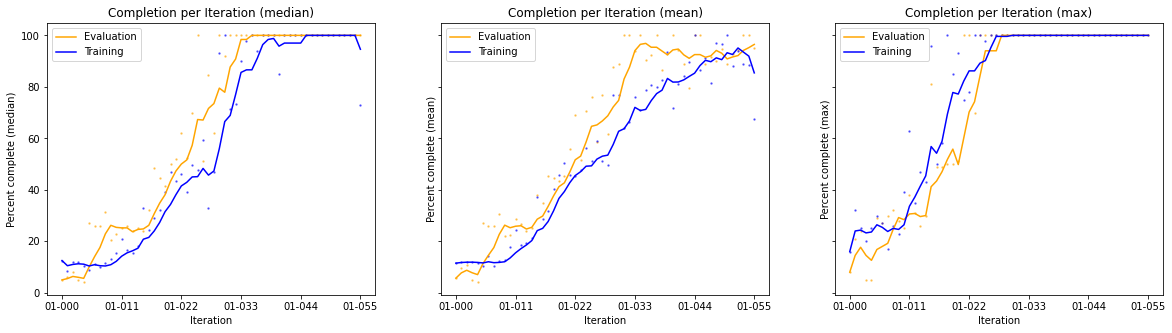

In [11]:
tm.plotProgress(method=['median','mean','max'], rolling_average=5, figsize=(20,5), rounds=rounds[:,0])

### Best laps

The following rounds will show the fastest 5 training and evaluation laps.

In [15]:
train_complete_lr = train[(train['round']>(NUM_ROUNDS-1)) & (train['complete']==1)]
display(train_complete_lr.nsmallest(5,['time']))

,r-i,round,iteration,master_iteration,episode,r-e,worker,trial,phase,reward,completion,time,complete,start_time
734,01-049,1,49,49,500,1-0500,0,10,training,738,100,9.212,1,5237265
771,01-052,1,52,52,523,1-0523,0,3,training,780,100,9.421,1,5633962
654,01-044,1,44,44,446,1-0446,0,6,training,741,100,9.450,1,4403125
667,01-045,1,45,45,454,1-0454,0,4,training,779,100,9.455,1,4545727
637,01-043,1,43,43,434,1-0434,0,4,training,756,100,9.458,1,4232120


In [18]:
eval_complete_lr = ev[(ev['round']>(NUM_ROUNDS-1)) & (ev['complete']==1)]
display(eval_complete_lr.nsmallest(5,['time']))

,r-i,round,iteration,master_iteration,episode,r-e,worker,trial,phase,reward,completion,time,complete,start_time
690,01-046,1,46,46,470,1-0470,0,10,evaluation,772,100,9.198,1,4781318
704,01-047,1,47,47,480,1-0480,0,10,evaluation,685,100,9.305,1,4916996
662,01-044,1,44,44,450,1-0450,0,10,evaluation,711,100,9.309,1,4492916
780,01-052,1,52,52,530,1-0530,0,10,evaluation,767,100,9.335,1,5725527
573,01-038,1,38,38,390,1-0390,0,10,evaluation,756,100,9.449,1,3590993


### Best lap progression

The below plot will show how the best laps for training and evaluation changes over time. This is useful to see if your model gets faster over time.

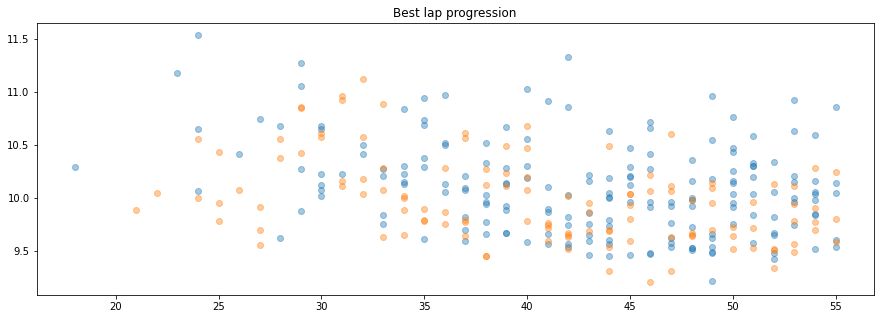

In [20]:
plt.figure(figsize=(15,5))
plt.title('Best lap progression')
plt.scatter(train_complete_lr['master_iteration'],train_complete_lr['time'],alpha=0.4)
plt.scatter(eval_complete_lr['master_iteration'],eval_complete_lr['time'],alpha=0.4)
plt.show()

### Lap progress

The below shows the completion for each training and evaluation episode.

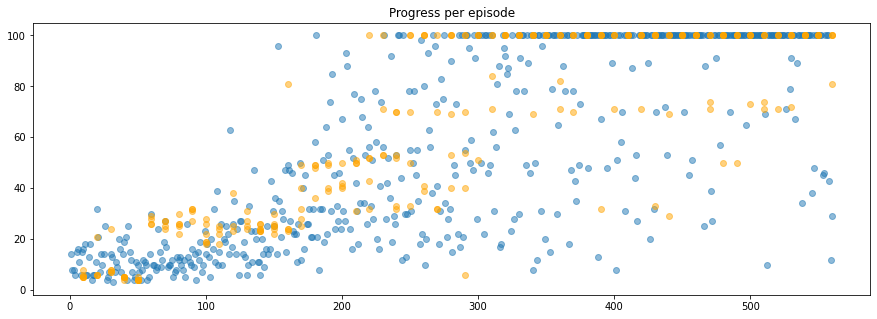

In [21]:
plt.figure(figsize=(15,5))
plt.title('Progress per episode')
train_r = train[train['round']==NUM_ROUNDS]
eval_r = ev[ev['round']==NUM_ROUNDS]
plt.scatter(train_r['episode'],train_r['completion'],alpha=0.5)
plt.scatter(eval_r['episode'],eval_r['completion'],c='orange',alpha=0.5)
plt.show()